<a href="https://colab.research.google.com/github/miguelwy/DataS/blob/master/ASHRAE_Energy_Prediction_lll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASHRAE - Energy Prediction III


In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ashrae-energy-prediction
!unzip train.csv.zip
!unzip test.csv.zip
!unzip weather_test.csv.zip
!unzip weather_train.csv.zip
!unzip sample_submission.csv.zip

Saving kaggle.json to kaggle.json
 94% 113M/120M [00:01<00:00, 44.2MB/s] 
100% 120M/120M [00:01<00:00, 71.1MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.8MB/s]
100% 88.4M/88.4M [00:02<00:00, 37.3MB/s]

  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 44.2MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 179MB/s]
 91% 152M/167M [00:02<00:00, 34.7MB/s]
100% 167M/167M [00:03<00:00, 57.9MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  weather_train.csv.zip
  inflating: weather_train.csv       
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
# upload external building data
building_data = files.upload()

Saving building_metadata_external.csv to building_metadata_external.csv


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
import gc,warnings,datetime
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
#Create lightgbm model
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [0]:
#Load dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# building = pd.read_csv('building_metadata.csv') 
building = pd.read_csv('building_metadata_external.csv') # using external data with 2 new columns
weather_train = pd.read_csv('weather_train.csv')
weather_test = pd.read_csv('weather_test.csv')

#Separe row_ids for submission file
row_ids = test['row_id']
building.drop(['leed'],inplace=True,axis=1)
test.drop('row_id',inplace=True,axis=1)

In [0]:
'''Function to reduce the DF size'''
# source: https://www.kaggle.com/kernels/scriptcontent/3684066/download

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
          if col == 'timestamp':
            print('Keeping timestamp...')
          else: 
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 616.95 MB
Keeping timestamp...
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 954.38 MB
Keeping timestamp...
Memory usage after optimization is: 437.43 MB
Decreased by 54.2%


In [0]:
# create column with log of readings for distribution normalization
train['meter_reading_log1p'] = np.log1p(train['meter_reading'])

# converting timestamp to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

# create date columns using train dataset
train['timestamp_hour'] = train.timestamp.dt.hour
train['timestamp_day'] = train.timestamp.dt.day # -> possibly overfitting
# train['timestamp_month'] = train.timestamp.dt.month -> possibly overfitting
# train['timestamp_year'] = train.timestamp.dt.year -> possibly overfitting
train['timestamp_weekday'] = train.timestamp.dt.weekday

# create date columns using test dataset
test['timestamp_hour'] = test.timestamp.dt.hour
test['timestamp_day'] = test.timestamp.dt.day # -> possibly overfitting
# test['timestamp_month'] = test.timestamp.dt.month -> possibly overfitting
# test['timestamp_year'] = test.timestamp.dt.year -> possibly overfitting
test['timestamp_weekday'] = test.timestamp.dt.weekday

In [0]:
# fill missing values in wheater train data set using interpolation
weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test = weather_test.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

# fill missing values in building_data set using interpolation
building = building.groupby('building_id').apply(lambda group: group.interpolate(limit_direction='both'))

# fill the remaining values with the median
b_cols = ['floor_count','year_built','eui']
for c in b_cols:
  building[c].fillna(building[c].median(),inplace=True)
b_cols = ['cloud_coverage','precip_depth_1_hr','sea_level_pressure']
for c in b_cols:
  weather_train[c].fillna(weather_train[c].median(),inplace=True)
  weather_test[c].fillna(weather_test[c].median(),inplace=True)

In [0]:
# merge building data
train = train.merge(building, on = 'building_id', how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')
# merge weather data
train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

# delete unecessary data
del weather_test,weather_train,building
gc.collect()

0

In [0]:
# all eletricity values until March 20 for site_id == 0 are 0,so we'll remove them
to_remove = train.loc[(train.building_id <= 104) & (train.meter == 0) & (train.timestamp <= datetime.date(2016,5,20))]
train.drop(to_remove.index,axis=0,inplace=True)

# we can drop the timestamp column now
train.drop(['timestamp'],axis=1,inplace=True)
test.drop(['timestamp'],axis=1,inplace=True)

In [0]:
# encode primary_use column using LabelEncoder
le = LabelEncoder()
train.loc[:,'primary_use'] = le.fit_transform(train.primary_use)
test.loc[:,'primary_use'] = le.fit_transform(test.primary_use)

In [0]:
#We can drop null rows 'cause they mean that there is no corresponding in the weather data for the site_id
train.dropna(axis =0,inplace=True)

b_cols = ['cloud_coverage','precip_depth_1_hr','sea_level_pressure','dew_temperature','wind_direction','wind_speed','air_temperature']
for c in b_cols:
  test[c].fillna(test[c].median(),inplace=True)

In [0]:
# create X and y for model input
train = reduce_mem_usage(train)
y = train.meter_reading_log1p
X = train.drop(['meter_reading_log1p'],axis=1)
X.drop(['meter_reading'],axis=1,inplace=True)
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

gc.collect()

Memory usage of dataframe is 2923.78 MB
Memory usage after optimization is: 886.57 MB
Decreased by 69.7%


0

In [0]:
X.drop(['wind_direction','wind_speed','sea_level_pressure'],axis=1,inplace=True)

In [0]:
X.drop(['timestamp_month'],axis=1,inplace=True)

In [0]:
params = {
              'boosting_type': 'gbdt',
              'objective': 'regression',
              'metric': {'rmse'},
              # 'subsample': 0.25,
              # 'subsample_freq': 1,
              'learning_rate': 0.05, # best = .3
              'num_leaves': 40, # best = 4
              'feature_fraction': 0.7, # best = .7
              'reg_lambda': 2, # best  = 1 
              # 'lambda_l2': 1, # best = 1
              'max_depth':8, #best  = 2
              # 'baggin_fraction':0.7,
              # 'min_data':100
              }
cat_feat = ["site_id", "building_id", "primary_use", "meter"]
folds = 4
seed = 55
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed) # shuffle or not

def train_model(x_,y_):
  # oof_pred = np.zeros(train.shape[0])  # out of fold predictions
  models = []
  ## stratify data by building_id
  for train_index, val_index in tqdm(kf.split(x_, x_['meter'])):
    train_X = x_.iloc[train_index]
    val_X = x_.iloc[val_index]
    train_y = y_.iloc[train_index]
    val_y = y_.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=cat_feat)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=cat_feat)
    gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=(lgb_train, lgb_eval),
                  early_stopping_rounds=100,
                  verbose_eval = 100
                  )
    models.append(gbm)
    del lgb_train,lgb_eval
    gc.collect()
  return models

# submission training
models = train_model(X,y)





0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.18202	valid_1's rmse: 1.18181
[200]	training's rmse: 1.06138	valid_1's rmse: 1.06117
[300]	training's rmse: 1.0161	valid_1's rmse: 1.01594
[400]	training's rmse: 0.989771	valid_1's rmse: 0.989689






1it [06:07, 367.39s/it]

[500]	training's rmse: 0.974087	valid_1's rmse: 0.97407
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.974087	valid_1's rmse: 0.97407
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.18158	valid_1's rmse: 1.18231
[200]	training's rmse: 1.06528	valid_1's rmse: 1.06608
[300]	training's rmse: 1.02282	valid_1's rmse: 1.02375
[400]	training's rmse: 0.994377	valid_1's rmse: 0.995603






2it [12:24, 370.38s/it]

[500]	training's rmse: 0.977232	valid_1's rmse: 0.978638
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.977232	valid_1's rmse: 0.978638
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.18468	valid_1's rmse: 1.18451
[200]	training's rmse: 1.06157	valid_1's rmse: 1.06168
[300]	training's rmse: 1.01629	valid_1's rmse: 1.01653
[400]	training's rmse: 0.986896	valid_1's rmse: 0.987333






3it [18:59, 377.67s/it]

[500]	training's rmse: 0.969609	valid_1's rmse: 0.970259
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.969609	valid_1's rmse: 0.970259
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.18386	valid_1's rmse: 1.18455
[200]	training's rmse: 1.069	valid_1's rmse: 1.07007
[300]	training's rmse: 1.01862	valid_1's rmse: 1.01987
[400]	training's rmse: 0.993256	valid_1's rmse: 0.994611






4it [25:31, 382.01s/it]





[500]	training's rmse: 0.977343	valid_1's rmse: 0.978879
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.977343	valid_1's rmse: 0.978879


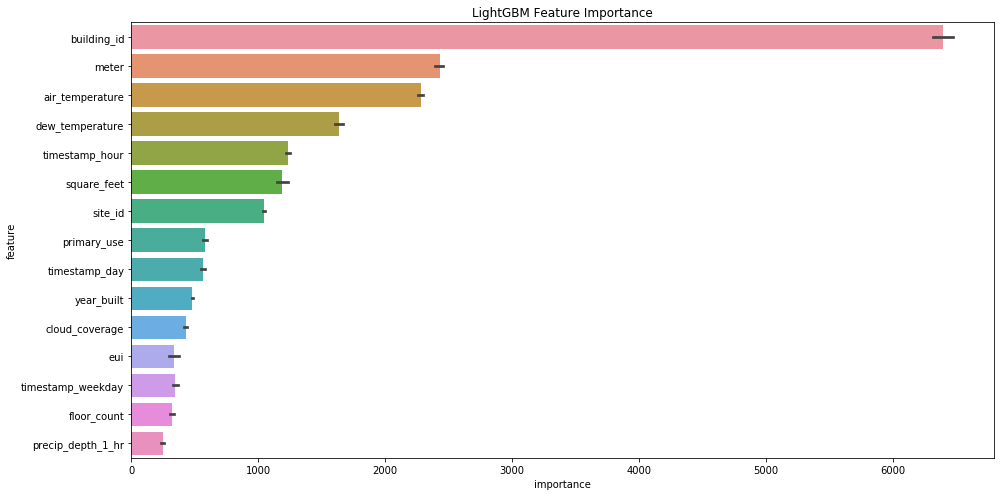

In [0]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X.columns.values
df_fimp_1["importance"] = models[0].feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X.columns.values
df_fimp_2["importance"] = models[1].feature_importance()
df_fimp_2["half"] = 2

df_fimp_3 = pd.DataFrame()
df_fimp_3["feature"] = X.columns.values
df_fimp_3["importance"] = models[2].feature_importance()
df_fimp_3["half"] = 2

df_fimp_4 = pd.DataFrame()
df_fimp_4["feature"] = X.columns.values
df_fimp_4["importance"] = models[3].feature_importance()
df_fimp_4["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2,df_fimp_3,df_fimp_4], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [0]:
#Predict using models
def predict_using_models(df):
  i=0
  result=[]
  step_size = 50000
  for j in tqdm(range(int(np.ceil(df.shape[0]/50000)))):
      result.append(np.expm1(sum([model.predict(df.iloc[i:i+step_size]) for model in models])/folds))
      i+=step_size
  result = np.concatenate(result)
  return result

result = predict_using_models(test)





  0%|          | 0/834 [00:00<?, ?it/s]



  0%|          | 1/834 [00:03<53:48,  3.88s/it]



  0%|          | 2/834 [00:07<54:00,  3.89s/it]



  0%|          | 3/834 [00:11<54:02,  3.90s/it]



  0%|          | 4/834 [00:15<53:58,  3.90s/it]



  1%|          | 5/834 [00:19<53:54,  3.90s/it]



  1%|          | 6/834 [00:23<53:59,  3.91s/it]



  1%|          | 7/834 [00:27<53:57,  3.92s/it]



  1%|          | 8/834 [00:31<53:46,  3.91s/it]



  1%|          | 9/834 [00:35<53:41,  3.91s/it]



  1%|          | 10/834 [00:39<53:31,  3.90s/it]



  1%|▏         | 11/834 [00:42<53:32,  3.90s/it]



  1%|▏         | 12/834 [00:46<53:20,  3.89s/it]



  2%|▏         | 13/834 [00:50<53:24,  3.90s/it]



  2%|▏         | 14/834 [00:54<53:27,  3.91s/it]



  2%|▏         | 15/834 [00:58<53:23,  3.91s/it]



  2%|▏         | 16/834 [01:02<53:16,  3.91s/it]



  2%|▏         | 17/834 [01:06<53:18,  3.92s/it]



  2%|▏         | 18/834 [01:10<53:11,  3.91s/it]



  2%|▏         | 19/834 [0

In [0]:
# Concatenate predictions and create submission file
submission = pd.read_csv("sample_submission.csv")
submission["meter_reading"] = result
submission.to_csv("submission.csv", index = False)

In [0]:
!kaggle competitions submit -c ashrae-energy-prediction -f 'submission.csv' -m "LGBM" 

100% 1.06G/1.06G [00:32<00:00, 34.9MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III